## Setup

In [5]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from pathlib import Path
import squarify
import networkx as nx
import matplotlib.patheffects as pe
from adjustText import adjust_text
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="pandas only supports SQLAlchemy")


conn = pyodbc.connect(
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=Northwind;Trusted_Connection=yes;"
)

SQL_DIR = Path("sql")

In [6]:
def run_sql(file_name):
    """Read a .sql file and return the query result as a DataFrame"""
    with open(SQL_DIR / file_name, "r", encoding="utf-8") as f:
        query = f.read()
    return pd.read_sql(query, conn)


### Which products have sold the most units?

In [7]:
df_q1 = run_sql("q1_top_products_by_units_sold.sql")
df_q1


,ProductName,UnitsSold
0,Camembert Pierrot,1577
1,Raclette Courdavault,1496
2,Gorgonzola Telino,1397
3,Gnocchi di nonna Alice,1263
4,Pavlova,1158
5,Rhönbräu Klosterbier,1155
6,Guaraná Fantástica,1125
7,Boston Crab Meat,1103
8,Tarte au sucre,1083
9,Chang,1057


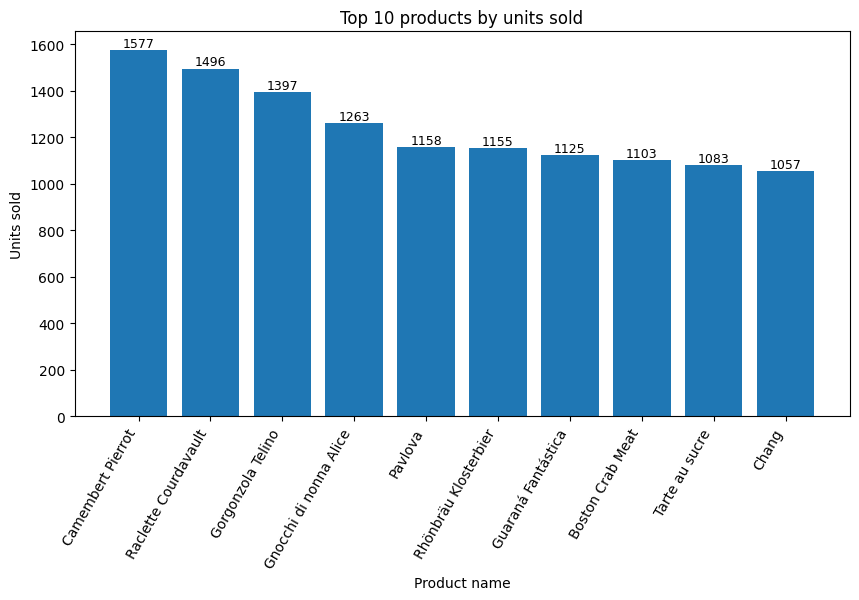

In [8]:
plt.figure(figsize=(10,5))
bars = plt.bar(df_q1["ProductName"], df_q1["UnitsSold"])
plt.title("Top 10 products by units sold")
plt.xlabel("Product name"); plt.ylabel("Units sold")
plt.xticks(rotation=60, ha="right")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        height,                            # y position (top of bar)
        f"{int(height)}",                  # label text
        ha="center", va="bottom", fontsize=9
    )
    
plt.show()


In [9]:
total_units = df_q1["UnitsSold"].sum()

# share of top 3 products
top3_share = df_q1["UnitsSold"].head(3).sum() / total_units * 100

print(f"Top 3 products account for {top3_share:.1f}% of units sold")

Top 3 products account for 36.0% of units sold


Sales are concentrated in a few key products: the top 3 alone account for over a third (36%) of all units sold. This suggests strong dependence on a small subset of the product catalog.

### Which products have generated the most revenue?


In [10]:
df_q2 = run_sql("q2_top_products_by_revenue.sql")
df_q2


,ProductName,Revenue
0,Côte de Blaye,141396.735229
1,Thüringer Rostbratwurst,80368.671997
2,Raclette Courdavault,71155.700027
3,Tarte au sucre,47234.969902
4,Camembert Pierrot,46825.480133
5,Gnocchi di nonna Alice,42593.060093
6,Manjimup Dried Apples,41819.650246
7,Alice Mutton,32698.379982
8,Carnarvon Tigers,29171.875000
9,Rössle Sauerkraut,25696.639832


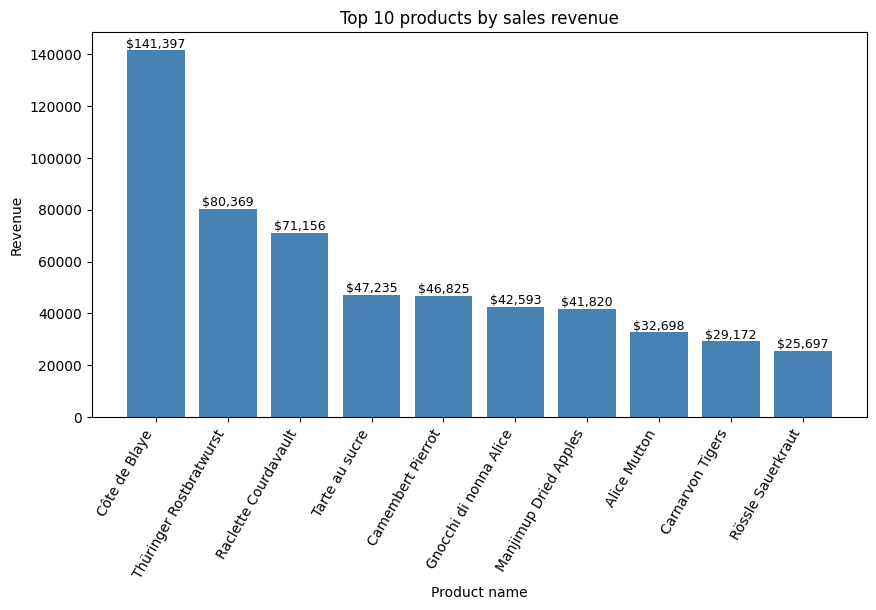

In [11]:
plt.figure(figsize=(10,5))
bars = plt.bar(df_q2["ProductName"], df_q2["Revenue"], color="steelblue")
plt.title("Top 10 products by sales revenue")
plt.xlabel("Product name"); plt.ylabel("Revenue")
plt.xticks(rotation=60, ha="right")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"${height:,.0f}", 
             ha="center", va="bottom", fontsize=9)

plt.show()


In [12]:
# total revenue of all products
total_revenue = pd.read_sql("""
    SELECT SUM(od.UnitPrice * od.Quantity * (1-od.Discount)) AS TotalRevenue
    FROM [Order Details] od
""", conn)["TotalRevenue"][0]

top10_revenue = df_q2["Revenue"].sum()
others_revenue = total_revenue - top10_revenue

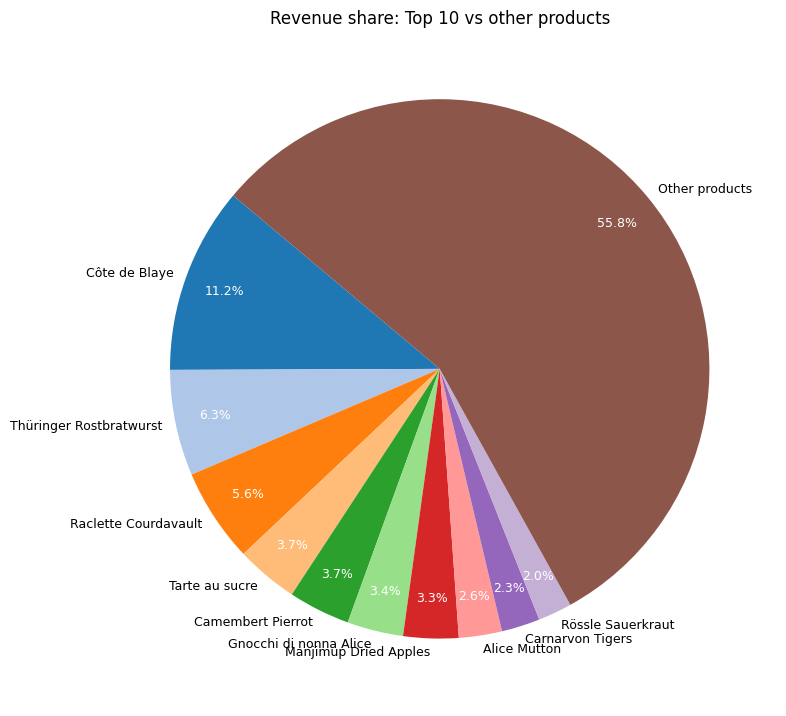

In [13]:
labels = list(df_q2["ProductName"]) + ["Other products"]
sizes = list(df_q2["Revenue"]) + [others_revenue]

# picking a colormap with enough distinct colors
colors = cm.tab20.colors[:len(labels)]

plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct="%1.1f%%", startangle=140,
    colors=colors, pctdistance=0.85, labeldistance=1.05
)

# adjusting text sizes
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_color("white")

plt.title("Revenue share: Top 10 vs other products")
plt.tight_layout()
plt.show()


The top 10 products together generate about 44% of total revenue, while the remaining products account for 56%. Revenue is therefore less concentrated than unit sales, although certain products like Cote de Blaye stand out, no single product dominates overall sales.

### Monthly orders and their revenue

In [14]:
df_q3 = run_sql("q3_monthly_orders_revenue.sql")
df_q3.head()

,MonthStart,Orders,Revenue
0,1996-07-01,22,27861.894974
1,1996-08-01,25,25485.274970
2,1996-09-01,23,26381.399973
3,1996-10-01,26,37515.725197
4,1996-11-01,25,45600.044844


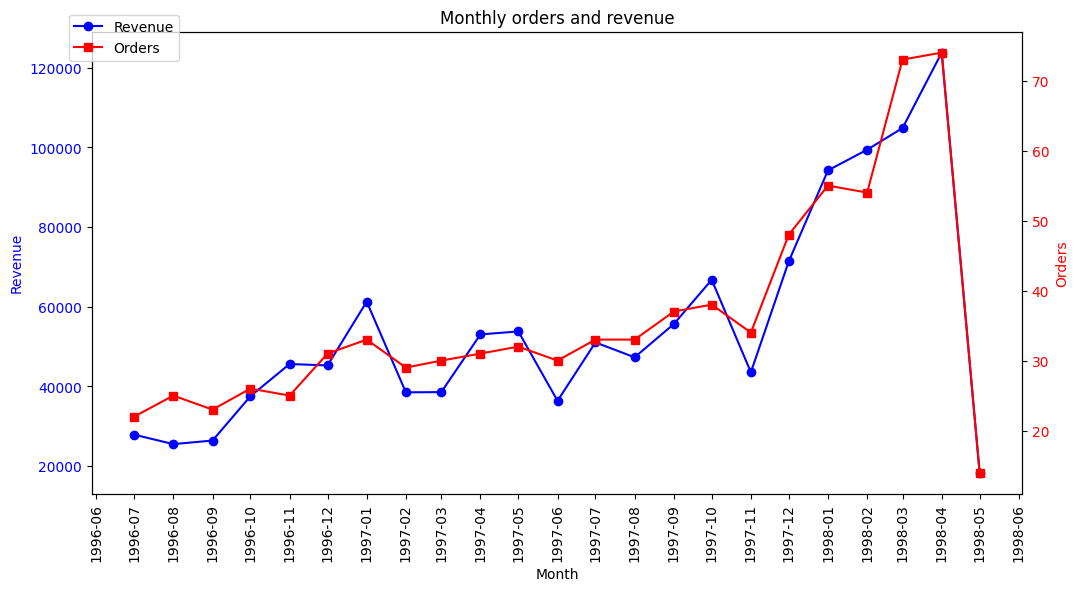

First month revenue: 27,862
Peak revenue: 123,799 in 1998-04
Growth: 344.3%


In [15]:


df_q3["MonthStart"] = pd.to_datetime(df_q3["MonthStart"])
df_q3 = df_q3.sort_values("MonthStart")

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_title("Monthly orders and revenue")
ax1.set_xlabel("Month")
ax1.set_ylabel("Revenue", color="blue")
l1, = ax1.plot(df_q3["MonthStart"], df_q3["Revenue"], color="blue", marker="o", label="Revenue")
ax1.tick_params(axis="y", labelcolor="blue")

# showing every month on the plot
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax1.get_xticklabels(), rotation=90)

ax2 = ax1.twinx()
ax2.set_ylabel("Orders", color="red")
l2, = ax2.plot(df_q3["MonthStart"], df_q3["Orders"], color="red", marker="s", label="Orders")
ax2.tick_params(axis="y", labelcolor="red")

# one combined legend (grabbing handles from both axes)
fig.legend(handles=[l1, l2], loc="upper left", bbox_to_anchor=(0.1, 0.92))
plt.show()

first_rev = df_q3["Revenue"].iloc[0]
peak_rev = df_q3["Revenue"].max()
peak_month = df_q3.loc[df_q3["Revenue"].idxmax(), "MonthStart"]

growth_pct = (peak_rev - first_rev) / first_rev * 100

print(f"First month revenue: {first_rev:,.0f}")
print(f"Peak revenue: {peak_rev:,.0f} in {peak_month.strftime('%Y-%m')}")
print(f"Growth: {growth_pct:.1f}%")

Revenue increased from 27,862 in the first recorded month to 123,799 in April 1998 - a growth of 344%. This strong upward trend shows both a rise in the number of orders and higher value transactions.

### Revenue by category

In [16]:
df_q4 = run_sql("q4_revenue_by_category.sql")
df_q4

,CategoryName,Revenue
0,Beverages,267868.180523
1,Dairy Products,234507.285217
2,Confections,167357.224832
3,Meat/Poultry,163022.359089
4,Seafood,131261.737425
5,Condiments,106047.084990
6,Produce,99984.580069
7,Grains/Cereals,95744.587475


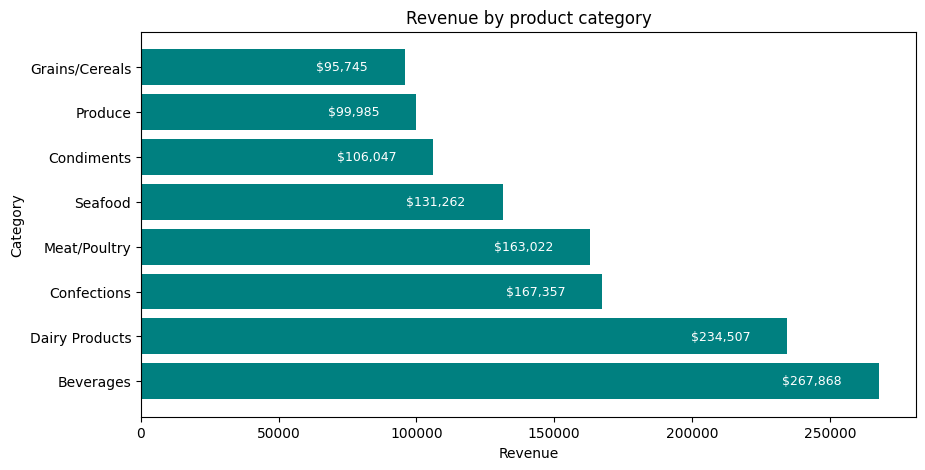

In [17]:
plt.figure(figsize=(10, 5))
bars = plt.barh(df_q4["CategoryName"], df_q4["Revenue"], color="teal")

plt.title("Revenue by product category")
plt.xlabel("Revenue")
plt.ylabel("Category")

for bar in bars:
    width = bar.get_width()
    plt.text(width - (df_q4["Revenue"].max()*0.05),   # a little left of the edge
             bar.get_y() + bar.get_height()/2,
             f"${width:,.0f}", va="center", ha="right", fontsize=9, color="white")

plt.show()

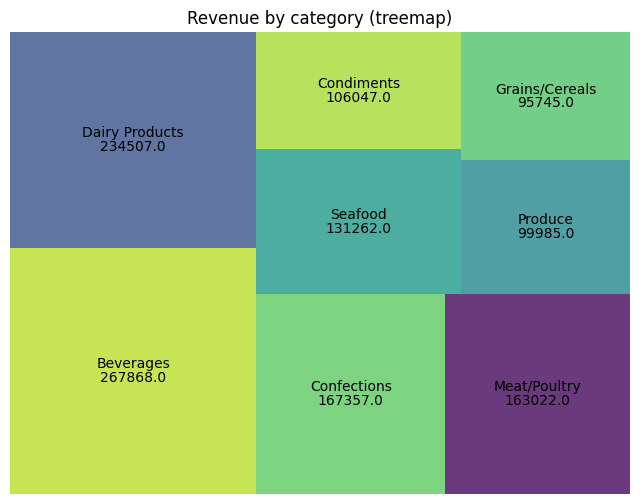

In [18]:
plt.figure(figsize=(8,6))
squarify.plot(
    sizes=df_q4["Revenue"],
    label=df_q4["CategoryName"],
    value=df_q4["Revenue"].round(0),
    alpha=0.8
)
plt.title("Revenue by category (treemap)")
plt.axis("off")
plt.show()


Beverages and Dairy Products are the top revenue drivers, together making up over 40% of total sales. In contrast, categories like Grains/Cereals or Produce contribute the least, which might mean reliance on the top two categories.

### Customer concentration risk: are the sales dependent on a few big clients?

In [19]:
df_q5 = run_sql("q5_top_customers.sql")
df_q5.head()

,CustomerID,CompanyName,Orders,Revenue,TotalRevenue
0,QUICK,QUICK-Stop,28,110277.304977,1.265793e+06
1,ERNSH,Ernst Handel,30,104874.978714,1.265793e+06
2,SAVEA,Save-a-lot Markets,31,104361.949921,1.265793e+06
3,RATTC,Rattlesnake Canyon Grocery,18,51097.800333,1.265793e+06
4,HUNGO,Hungry Owl All-Night Grocers,19,49979.905001,1.265793e+06


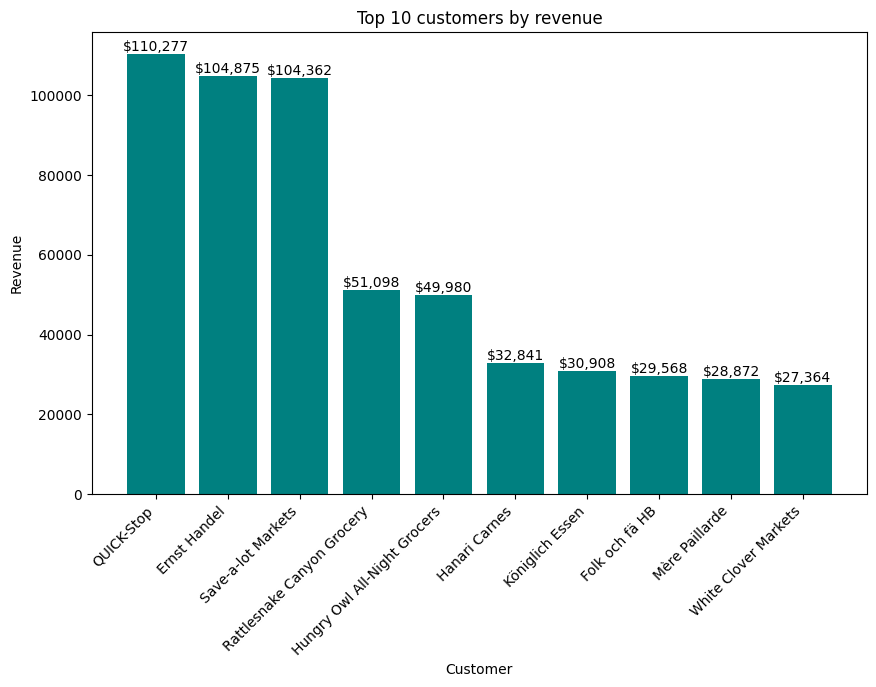

In [20]:
plt.figure(figsize=(10,6))
bars = plt.bar(df_q5["CompanyName"], df_q5["Revenue"], color="teal")
plt.title("Top 10 customers by revenue")
plt.xlabel("Customer")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")

for bar, rev in zip(bars, df_q5["Revenue"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"${rev:,.0f}", ha="center", va="bottom")

plt.show()

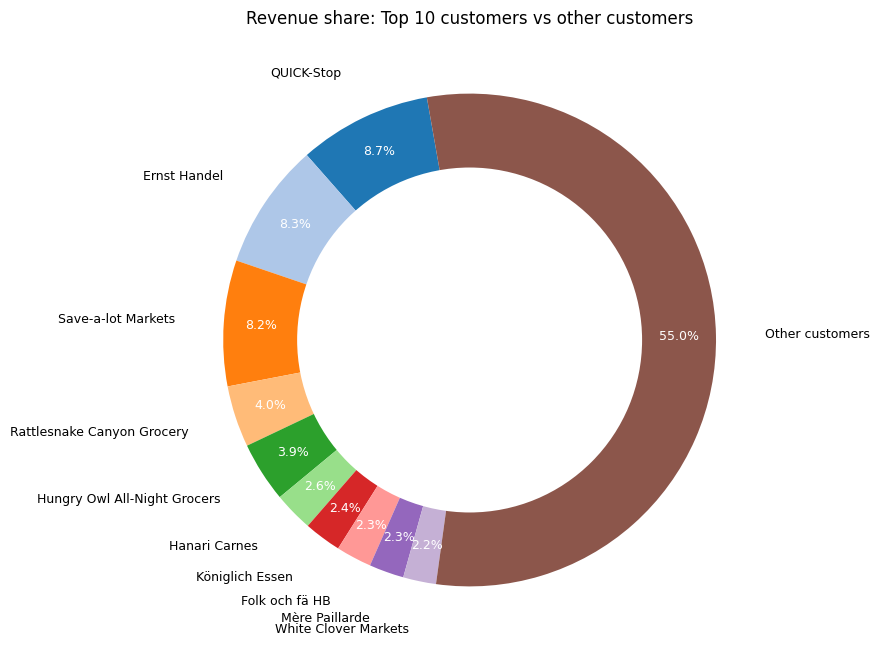

In [21]:
top10_revenue = df_q5["Revenue"].sum()
all_revenue = df_q5["TotalRevenue"].iloc[0]
others = all_revenue - top10_revenue

labels = list(df_q5["CompanyName"]) + ["Other customers"]
sizes  = list(df_q5["Revenue"]) + [others]

# picking a colormap with enough distinct colors
colors = cm.tab20.colors[:len(labels)]

plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct="%1.1f%%",
    startangle=100,          # rotated to spread labels
    colors=colors, pctdistance=0.85, labeldistance=1.2
)

# making labels smaller & percentages readable
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_color("white")

# donut hole
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Revenue share: Top 10 customers vs other customers")
plt.show()


Although there are 91 customers in total, the top 10 customers contribute ~45% of total revenue, showing that sales are concentrated among a small but very valuable customer group.

### Employee performance ranking

In [22]:
df_q6 = run_sql("q6_employee_sales.sql")
df_q6.head()

,EmployeeID,EmployeeName,Orders,Revenue,AverageOrderValue
0,4,Peacock Margaret,156,232890.845947,1492.890038
1,3,Leverling Janet,127,202812.842793,1596.951518
2,1,Davolio Nancy,123,192107.604321,1561.850442
3,2,Fuller Andrew,96,166537.754978,1734.768281
4,8,Callahan Laura,104,126862.277704,1219.829593


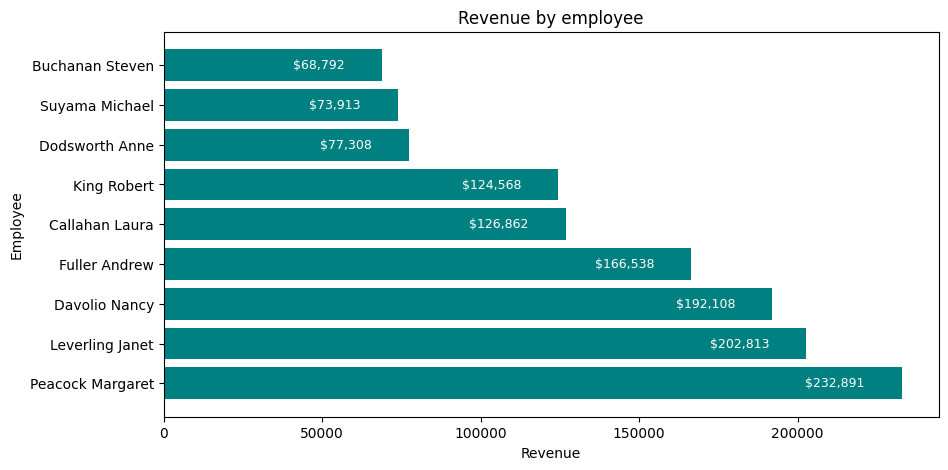

In [23]:
plt.figure(figsize=(10,5))
bars = plt.barh(df_q6["EmployeeName"], df_q6["Revenue"], color="teal")

plt.title("Revenue by employee")
plt.xlabel("Revenue")
plt.ylabel("Employee")

for bar in bars:
    width = bar.get_width()
    plt.text(width - (df_q6["Revenue"].max()*0.05),
             bar.get_y() + bar.get_height()/2,
             f"${width:,.0f}", va="center", ha="right", fontsize=9, color="white")

plt.show()

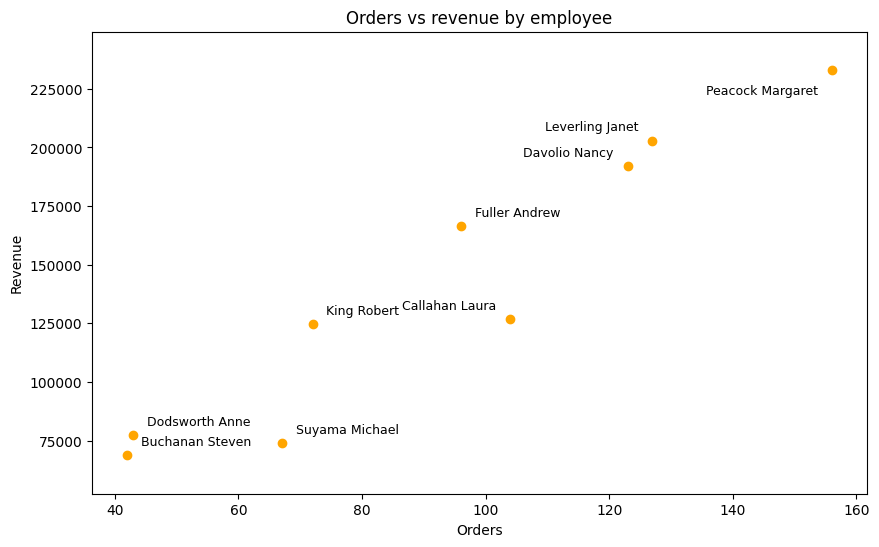

In [24]:
plt.figure(figsize=(10,6))
plt.scatter(df_q6["Orders"], df_q6["Revenue"], color="orange")

plt.title("Orders vs revenue by employee")
plt.xlabel("Orders")
plt.ylabel("Revenue")

# adding some margins so labels have enough space
plt.margins(x=0.05, y=0.1)

# annotating with offsets so labels stay inside the frame
for i, row in df_q6.iterrows():
    x, y = row["Orders"], row["Revenue"]
    ha = "right" if x > df_q6["Orders"].median() else "left"  # align left/right based on position
    va = "bottom" if y < df_q6["Revenue"].max() else "top"    # align top if at max revenue
    plt.annotate(row["EmployeeName"], 
                 (x, y),
                 xytext=(-10 if ha=="right" else 10, 5 if va=="bottom" else -10),
                 textcoords="offset points",
                 ha=ha, va=va, fontsize=9)

plt.show()

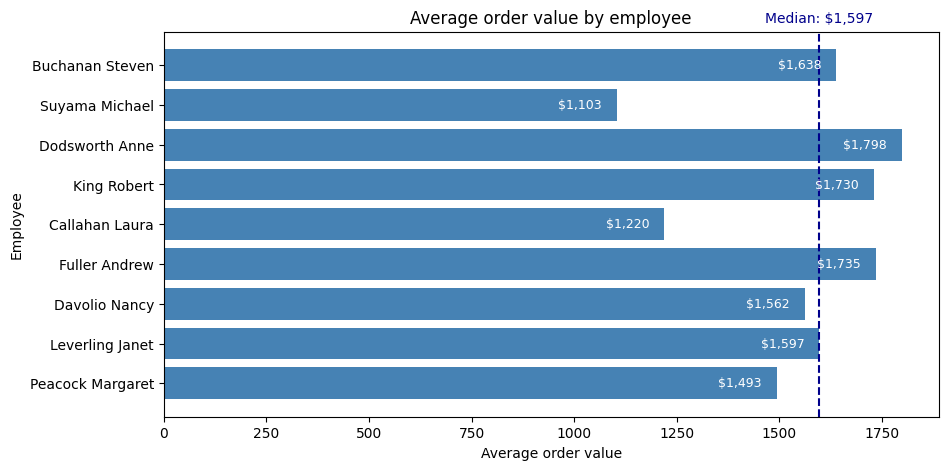

In [25]:
plt.figure(figsize=(10,5))
bars = plt.barh(df_q6["EmployeeName"], df_q6["AverageOrderValue"], color="steelblue")

for bar, value in zip(bars, df_q6["AverageOrderValue"]):
    plt.text(value - (df_q6["AverageOrderValue"].max() * 0.02),  # slightly inside
             bar.get_y() + bar.get_height()/2,
             f"${value:,.0f}", va="center", ha="right", fontsize=9, color="white")

# median line
median = df_q6["AverageOrderValue"].median()
plt.axvline(median, linestyle="--", color="darkblue")

plt.text(median, len(df_q6), f"Median: ${median:,.0f}",
         ha="center", va="bottom", color="darkblue", fontsize=10)

plt.title("Average order value by employee")
plt.xlabel("Average order value")
plt.ylabel("Employee")
plt.show()



### Apriori-style market basket analysis

In [26]:
df_q7 = run_sql("q7_apriori_style_market_basket_analysis.sql")
df_q7.head()

,ProductA,ProductB,PairCount,Support,ConfidenceAtoB,ConfidenceBtoA,Lift
0,Sir Rodney's Scones,Sirop d'érable,8,0.010,0.205,0.333,7.094
1,Pavlova,Gorgonzola Telino,7,0.008,0.163,0.137,2.649
2,Nord-Ost Matjeshering,Tourtière,6,0.007,0.188,0.167,4.323
3,Gorgonzola Telino,Mozzarella di Giovanni,6,0.007,0.118,0.158,2.570
4,Pavlova,Tarte au sucre,6,0.007,0.140,0.125,2.413


#### Network graph of product assiociations

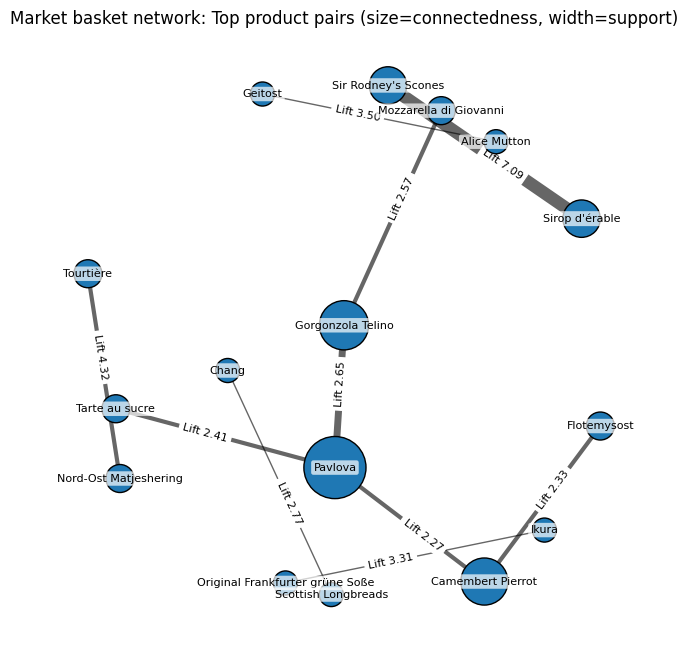

In [27]:
TOP_EDGES = 15
df_vis = (
    df_q7.sort_values(["Lift"], ascending=False)
         .head(TOP_EDGES)
         .reset_index(drop=True)
)

G = nx.Graph()

# adding weighted edges
for _, r in df_vis.iterrows():
    a, b = r["ProductA"], r["ProductB"]
    G.add_edge(a, b, support=float(r["Support"]), lift=float(r["Lift"]), paircount=int(r.get("PairCount", 0)))

# node importance (size) = sum of supports of incident edges
node_strength = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    s = d.get("support", 0.0)
    node_strength[u] += s
    node_strength[v] += s

# scale node sizes
vals = np.array(list(node_strength.values()))
if len(vals) == 0:
    vals = np.array([1.0])
min_size, max_size = 300, 2000
if vals.max() > 0:
    node_sizes = min_size + (vals - vals.min()) / (vals.max() - vals.min() + 1e-12) * (max_size - min_size)
else:
    node_sizes = np.full_like(vals, (min_size + max_size)/2, dtype=float)
node_size_map = {n: sz for n, sz in zip(node_strength.keys(), node_sizes)}

# edge width = scaled by support
supports = np.array([d["support"] for _,_,d in G.edges(data=True)])
if supports.size == 0:
    supports = np.array([0.0])
edge_widths = 1 + 8 * (supports - supports.min()) / (supports.max() - supports.min() + 1e-12)

# slightly spread layout
pos = nx.spring_layout(G, seed=42, k=1.3)

plt.figure(figsize=(8,8))

nx.draw_networkx_nodes(
    G, pos,
    node_size=[node_size_map[n] for n in G.nodes()],
    linewidths=1, edgecolors="black"
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.6
)

# node labels with white background box
nx.draw_networkx_labels(
    G, pos, font_size=8, font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
)

# edge labels: show Lift (rounded), move slightly along edges
edge_labels = {(u, v): f"Lift {d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

plt.title("Market basket network: Top product pairs (size=connectedness, width=support)")
plt.axis("off")
plt.show()


#### Heatmap (products x products, coloured by Lift)

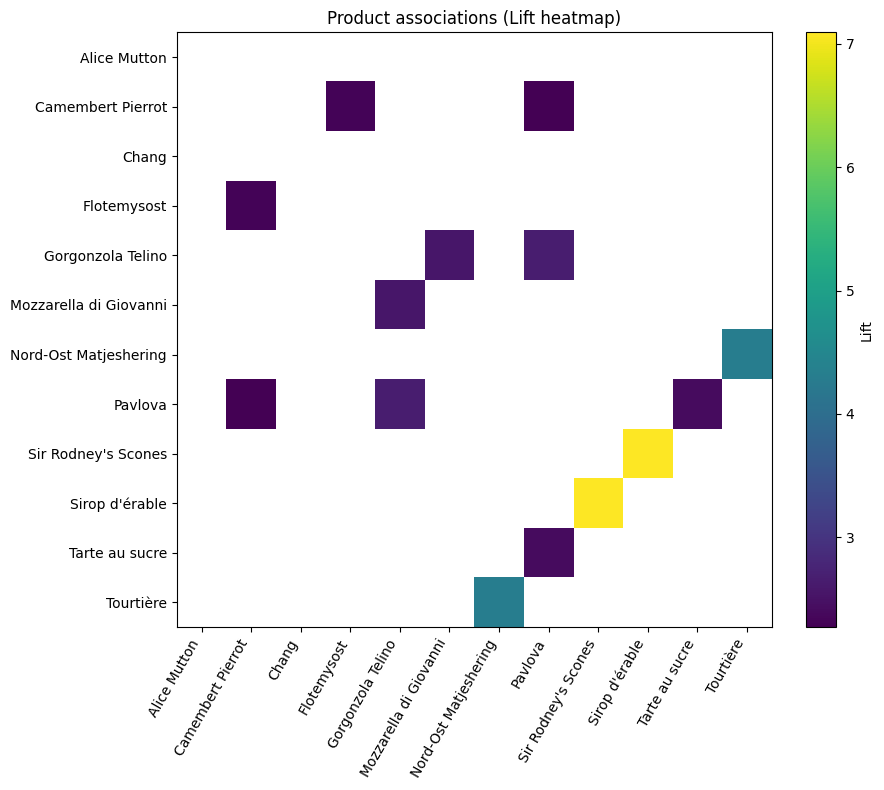

In [28]:
top_k = 12
strength = (
    pd.concat([
        df_q7.groupby("ProductA")["Support"].sum(),
        df_q7.groupby("ProductB")["Support"].sum()
    ]).groupby(level=0).sum().sort_values(ascending=False)
)
keep = set(strength.head(top_k).index)

df_hm = df_q7[df_q7["ProductA"].isin(keep) & df_q7["ProductB"].isin(keep)].copy()

# symmetric matrix of Lift
pivot = df_hm.pivot_table(index="ProductA", columns="ProductB", values="Lift", aggfunc="max")
pivot = pivot.reindex(index=sorted(keep), columns=sorted(keep))
# mirror upper to lower triangle for nicer look
pivot_full = pivot.combine_first(pivot.T)
np.fill_diagonal(pivot_full.values, np.nan)  # hide diagonal

plt.figure(figsize=(10,8))
im = plt.imshow(pivot_full, aspect="equal")
plt.xticks(range(len(pivot_full.columns)), pivot_full.columns, rotation=60, ha="right")
plt.yticks(range(len(pivot_full.index)), pivot_full.index)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Lift")
plt.title("Product associations (Lift heatmap)")
plt.tight_layout()
plt.show()

#### Scatter plot (Support vs Lift, size by Confidence)

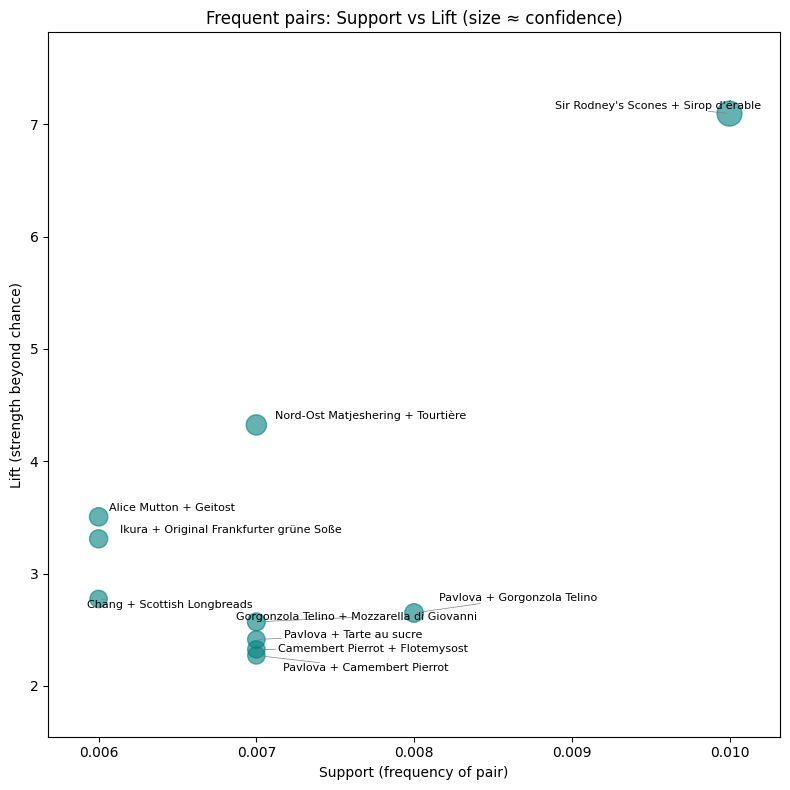

In [29]:
plt.figure(figsize=(8,8))

# bubble size ~ average confidence
avg_conf = 0.5*(df_q7["ConfidenceAtoB"] + df_q7["ConfidenceBtoA"])
plt.scatter(df_q7["Support"], df_q7["Lift"], s=avg_conf*1200, color="teal", alpha=0.6)

plt.title("Frequent pairs: Support vs Lift (size ≈ confidence)")
plt.xlabel("Support (frequency of pair)")
plt.ylabel("Lift (strength beyond chance)")
plt.margins(x=0.08, y=0.15)

# collect text objects
texts = []
for _, row in df_q7.iterrows():
    texts.append(
        plt.text(
            row["Support"], row["Lift"],
            f"{row['ProductA']} + {row['ProductB']}",
            fontsize=8
        )
    )


adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

plt.tight_layout()
plt.show()


We've identified product pairs that frequently co-occur in customer orders. For example, “Sir Rodney’s Scones” and “Sirop d’érable” show the strongest association (high lift ≈ 7), meaning these two products are bought together far more often than expected by chance. These results highlight opportunities for cross-selling and bundling strategies. Retailers could promote these pairs together (for example combo deals, product placement) to increase sales.

### Exporting everything to CSV

In [32]:
SQL = {
    "q1_top_products_by_units_sold.sql":      "q1_top_products_units.csv",
    "q2_top_products_by_revenue.sql":         "q2_top_products_revenue.csv",
    "q3_monthly_orders_revenue.sql":          "q3_monthly_orders_revenue.csv",
    "q4_revenue_by_category.sql":             "q4_revenue_by_category.csv",
    "q5_top_customers.sql":        "q5_top_customers_with_total.csv",  # or q5_top_customers.sql if you used that
    "q6_employee_sales.sql":                  "q6_employee_sales.csv",
    "q7_apriori_style_market_basket_analysis.sql": "q7_apriori_pairs.csv",
}

Path("outputs").mkdir(exist_ok=True)

for sql_file, csv_file in SQL.items():
    df = run_sql(sql_file)
    df.to_csv(Path("outputs")/csv_file, index=False)
    print("Saved:", csv_file)


Saved: q1_top_products_units.csv
Saved: q2_top_products_revenue.csv
Saved: q3_monthly_orders_revenue.csv
Saved: q4_revenue_by_category.csv
Saved: q5_top_customers_with_total.csv
Saved: q6_employee_sales.csv
Saved: q7_apriori_pairs.csv
